### Hierarchical Agent

- For some applications, the system may be more effective f work is distributed hierarchically.
- You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.


In [43]:
from typing import Annotated, List, Dict, Optional, Literal

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain_tavily import TavilySearch

from langchain.tools import tool

from pathlib import Path
from tempfile import TemporaryDirectory

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import trim_messages, HumanMessage

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model



In [44]:
#tavily tool

tavily_tool = TavilySearch(max_results=3)

#custom tool for retriever

@tool
def scrape_webpages(urls:List[str])->str:
    "this function scrapes given urls and gives detailed information"
    loader= WebBaseLoader(web_paths=urls)
    docs = loader.load()
    return ("\n\n".join([f'<document name: "{doc.metadata.get("title", "")}">\n {doc.page_content}\n</Document>' for doc in docs]))

In [53]:
#tool for create_outline custom function
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections"],
    file_name: Annotated[str, "File path to save the outline"]
)-> Annotated[str, "Path of the saved outline file"]:
    "this function creates and saves an outline"
    with open(WORKING_DIRECTORY/file_name, "w") as file:
        for i, point in enumerate(points):
            file.write(f"{i+1}. {point}\n")

    return f"Outline saved to {file_name}" 


#write document tool creation

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document"],
    file_name: Annotated[str, "File path to save the document"]
)->Annotated[str, "Path of the saved document file"]:
    "this function creates and saves a text document"
    with open(WORKING_DIRECTORY/file_name, "w") as file:
        file.write(content)

    return  f"Document saved to {file_name}"  

#edit document tool creation

@tool
def edit_document(
    file_name: Annotated[str, "Path of document to be edited"],
    inserts: Annotated[Dict[int, str], "Dictionary where key is the line number and value is the text to be inserted at that line"]
)-> Annotated[str, "Path of the edited document file"]:
    "this function edits a document by inserting text at specific line numbers"

    with open(WORKING_DIRECTORY/file_name, "r")as file:
        lines = file.readlines()

        sorted_inserts = sorted(inserts.items())

        for line_number, text in sorted_inserts:
            if 1 <= line_number <= len(lines) + 1:
                lines.insert(line_number -1, text + "\n")
            else:
                return f"Error: Line number {line_number} is out of range"   

        with open(WORKING_DIRECTORY/file_name, "w") as file:
            file.writelines(lines) 

    return f"Document edited and saved to {file_name}" 

@tool
def read_document(
    file_name: Annotated[str, "File path to read the document"]
)->Annotated[str, "Path of the document file read"]:
    "this function reads a text document"
    with open(WORKING_DIRECTORY/file_name, "w") as file:
        file.read()

    return  f"Document read is {file_name}"          


In [46]:
#warning: this executes code locally, which can be unsafe when not sandboxed.

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "Python code to execute and generate your chart"]
):
    "this function excutes python code. If you want to see the output of a value,"
    "you should print it out with 'print(...)'.This is visible to the user."
    try:
        result = repl.run(code)
    except Exception as e:
        return f"failed to execute. Error: {repr(e)}"   

    return f"Successfully executed: \n```python\n {code}\n```\nStndout: {result}" 

In [47]:
class State(MessagesState):
    next:str

In [48]:
def make_supervisor_node(llm:BaseChatModel, members: List[str])->str:
    options= ['FINISH'] + members
    system_prompt = (
        f"""you are a supervisor tasked with managing a conversation between the following workers:
        {members}.Given the following user request, respond with the worker to act next. Each worker will perform a task
        and respond wwith their results and status. when finished reposnd with FINISH.
        
        """ 
    )

    class Router(TypedDict):
        """worker to route to next. If no workers needed, route to finish"""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        "An LLM-based router."
        messages = [
            {"role":"system", "content": system_prompt}
        ] + state['messages'] 

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response['next']
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node   

In [49]:
search_agent = create_agent(
    model=init_chat_model(model="groq:llama-3.1-8b-instant"),
    tools=[tavily_tool]
)

def search_agent_node(state:State)->Command[Literal['supervisor']]:
    result = search_agent.invoke(state)
    return Command(
        update={"messages":
                [HumanMessage(content=result['messages'][-1].content, name="search_agent")]},
                goto="supervisor"
    )

In [50]:
webscraper_agent = create_agent(
    model=init_chat_model("groq:llama-3.1-8b-instant"),
    tools=[scrape_webpages]
)

def webscraper_agent_node(state:State)->Command[Literal['supervisor']]:
    result = webscraper_agent.invoke(state)
    return Command(
        update={"messages":
                [HumanMessage(content=result['messages'][-1].content, name="webscraper_agent")]},
                goto="supervisor"
    )

In [51]:
model=init_chat_model(model='groq:llama-3.1-8b-instant')
research_supervisor_node = make_supervisor_node(llm=model, members=['search_agent', 'webscraper_agent'])

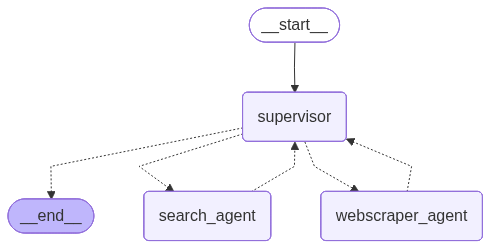

In [52]:
research_builder = StateGraph(State)

research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search_agent", search_agent_node)
research_builder.add_node("webscraper_agent", webscraper_agent_node)

research_builder.add_edge(START, "supervisor")

research_graph = research_builder.compile()
research_graph

In [55]:
doc_writer_agent = create_agent(
    model=model,
    tools=[read_document, write_document, edit_document],
)

def doc_writer_agent_node(state:State)->Command[Literal['supervisor']]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={"messgages": HumanMessage(content=result['messages'][-1].content, name="docwriter_agent")},
        goto="supervisor"

    )

note_taking_agent = create_agent(
    model=model,
    tools=[create_outline, read_document]
)

def note_taking_agent_node(state:State)->Command[Literal['supervisor']]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={"messgages": HumanMessage(content=result['messages'][-1].content, name="notetaking_agent")},
        goto="supervisor"

    )

chart_generating_agent = create_agent(model=model, tools=[read_document, python_repl_tool])

def chart_generating_agent_node(state:State)->Command[Literal['supervisor']]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={"messgages": HumanMessage(content=result['messages'][-1].content, name="chartgenerating_agent")},
        goto="supervisor"

    )




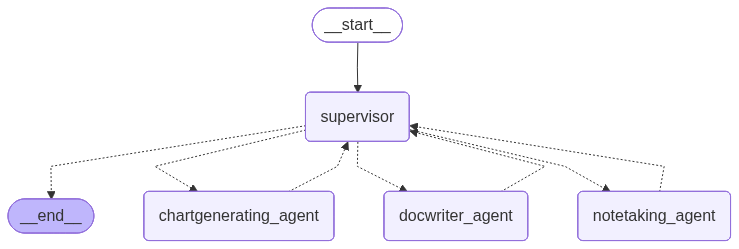

In [56]:
doc_writing_supervisor_node=make_supervisor_node(llm=model, members=['docwriter_agent','notetaking_agent','chartgenerating_agent'])

doc_writing_supervisor_builder = StateGraph(State)

doc_writing_supervisor_builder.add_node('docwriter_agent', doc_writer_agent_node)
doc_writing_supervisor_builder.add_node('notetaking_agent', note_taking_agent_node)
doc_writing_supervisor_builder.add_node('chartgenerating_agent', chart_generating_agent_node)
doc_writing_supervisor_builder.add_node('supervisor', doc_writing_supervisor_node)

doc_writing_supervisor_builder.add_edge(START, "supervisor")

doc_writing_supervisor_graph = doc_writing_supervisor_builder.compile()
doc_writing_supervisor_graph

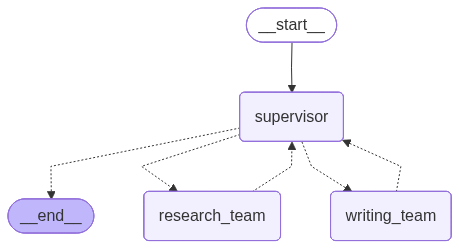

In [58]:
#creating hierarchical supervisor

superior_supervisor_node = make_supervisor_node(llm=model, members = ['research_team', 'writing_team'])

def research_team_node(state:State)->Command[Literal['supervisor']]:
    result= research_graph.invoke(state)
    return Command(
        update={"messages": HumanMessage(content=result['messages'][-1].content, name="research_team")},
                goto="supervisor"
    )

def writing_team_node(state:State)->Command[Literal['supervisor']]:
    result= research_graph.invoke(state)
    return Command(
        update={"messages": HumanMessage(content=result['messages'][-1].content, name="writing_team")},
                goto="supervisor"
    )

superior_supervisor_builder = StateGraph(State)

superior_supervisor_builder.add_node("research_team", research_team_node)
superior_supervisor_builder.add_node("writing_team", writing_team_node)
superior_supervisor_builder.add_node("supervisor", superior_supervisor_node)

superior_supervisor_builder.add_edge(START, "supervisor")

superior_supervisor_graph=superior_supervisor_builder.compile()
superior_supervisor_graph




In [ ]:
superior_response = superior_supervisor_graph.invoke(
    {"messages": "say about latest trends in ai"}
)


In [ ]:
superior_response